In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
dimension = 2
points = 5

In [54]:
def creerPoints(centre, rayon, nb_points=points, nb_dimensions=dimension):
    result = np.zeros((nb_points, nb_dimensions))
    for j in range(nb_dimensions):
        result[:, j] += centre[j]
    for i in range(nb_points):
        r = rayon*np.random.uniform(0, 1)
        theta = np.random.uniform(0, 2*np.pi)
        result[i, 0] += r*np.cos(theta)
        result[i, 1] += r*np.sin(theta)
    return result

def creerClusters(c1, r1, c2, r2, nb_dimensions=dimension, nb_points=points, createur=creerPoints):
    return createur(c1, r1, nb_points, nb_dimensions), createur(c2, r2, nb_points, nb_dimensions)

def euc_lin(p1, p2, nb_dimensions=dimension, hyperparametre=1):
    x = p2-p1
    return hyperparametre*np.sqrt(np.dot(x, x))

def euc_quadra(p1, p2, nb_dimensions=dimension, hyperparametre=1):
    x = p2-p1
    return hyperparametre*np.dot(x, x)

def cout(p1, p2, nb_dimensions=dimension, fct_cout=euc_quadra, hyperparametre=1):
    return fct_cout(p1, p2, nb_dimensions, hyperparametre)

def creerMatriceCout(source, destination, fct_cout=euc_quadra, hyperparametre=1):
    n, p = source.shape
    C = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            C[i, j] = cout(source[i, :], destination[j, :], fct_cout=fct_cout, hyperparametre=hyperparametre)
    return C

def est_sature(i, j, c, phi, psi):
    return phi[i]+psi[j] == c[i, j]

In [ ]:
def trouverChemin(adj, pos, switch, chemin, visite):
    n, _ = adj.shape

    for counter in range(n):
        if switch == 0 :
            if adj[pos][counter] == 1 and visite[pos][counter] == 0:
                chemin.append(counter)
                visite[pos][counter] = 1
                trouverChemin(adj, counter, not(switch), chemin, visite)
                break
        else :
            if adj[counter][pos] == 1 and visite[counter][pos] == 0:
                chemin.append(counter)
                visite[counter][pos] = 1
                trouverChemin(adj, counter, not(switch), chemin, visite)
                break

def inverser(x, chemin):
    for i in range(len(chemin)-1):
        if (i % 2 == 0):
            x[chemin[i], chemin[i+1]] = int(not(x[chemin[i], chemin[i+1]]))
        else:
            x[chemin[i+1], chemin[i]] = int(not(x[chemin[i+1], chemin[i]]))

def hongrois(source, destination):
    n, p = source.shape
    c = creerMatriceCout(source, destination) # np.array([[1, 4, 2], [3, 5, 6], [2, 1, 3]]) 
    x = np.zeros_like(c)
    adj = np.zeros_like(c) # matrice d'adjacence bipartite
    visite = np.zeros_like(c)
    phi = np.zeros(n)
    psi = np.zeros(n)

    # initialisation

    for i in range(n):
        phi[i] = np.min(c[i, :])
    
    for j in range(n):
        psi[j] = np.min(c[:, j]-phi)

    for i in range(n):
        for j in range(n):
            if est_sature(i, j, c, phi, psi):
                adj[i, j] = 1

    for i in range(n):
        for j in range(n):
            if (adj[i, j] == 1 and not(1 in x[:, j])):
                x[i, j] = 1
                break

    # boucle principale

    depart = None

    for i in range(n):
        if not(1 in x[i, :]):
            chemin = [i]
            trouverChemin(adj, 1, 0, chemin, visite) #pb, il faut que le chemin finisse à droite et soit pas trop petit
            inverser(x, chemin)

    # il faut rajouter la procedure quand on a pas de chemin augmentant (page 49)

    cout_transport = np.sum(phi)+np.sum(psi)

    return x, adj, cout_transport

def afficherClusters(source, destination):
    plt.plot(source[:, 0], source[:, 1], 'or')
    plt.plot(destination[:, 0], destination[:, 1], 'ob')
    plt.show()

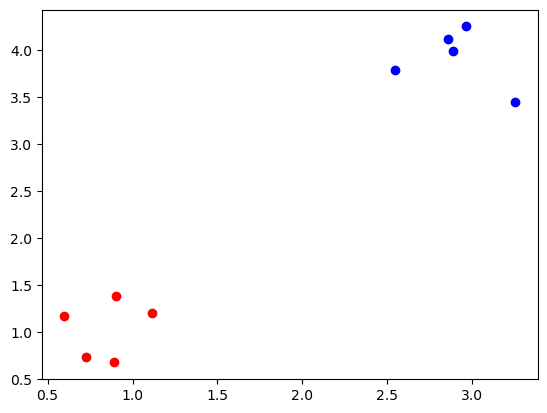

[[12.64179438 17.37992625 13.78080423 15.97422744 15.30069694]
 [ 8.50130884 12.49281524  9.82322468 11.29937435 10.77299213]
 [ 8.71057913 12.68470575  9.61018934 11.49172039 10.9077129 ]
 [10.67099269 15.11410182 12.27623336 13.79641742 13.23741523]
 [12.42342639 17.07692347 13.28631562 15.69216401 14.99282736]]


In [59]:
c1, r1 = [1, 1], 0.5
c2, r2 = [3, 4], 0.8

A, B = creerClusters(c1, r1, c2, r2)
C = creerMatriceCout(A, B, fct_cout=euc_quadra)

afficherClusters(A, B)
print(C)

In [64]:
x, adj, cout_transport = hongrois(A, B)
print("Assignations : ")
print(x)
print("Cout total du transport : ", cout_transport)

Assignations : 
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
Cout total du transport :  62.763392295702964
